In [1]:
import torch
from torchvision import transforms 
from Dataset import LFWtripletDataset
import matplotlib.pyplot as plt
import TriNetSiamese 
from TriNetSiamese import TriNetSiamese
import helper
import train

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
helper.set_random_seed()

Random seed set to: 13


Total People: 5758
Total Images: 13233
Max Images for a Person: 530
Total People with one Image: 4069
Total People with multiple Images: 1680


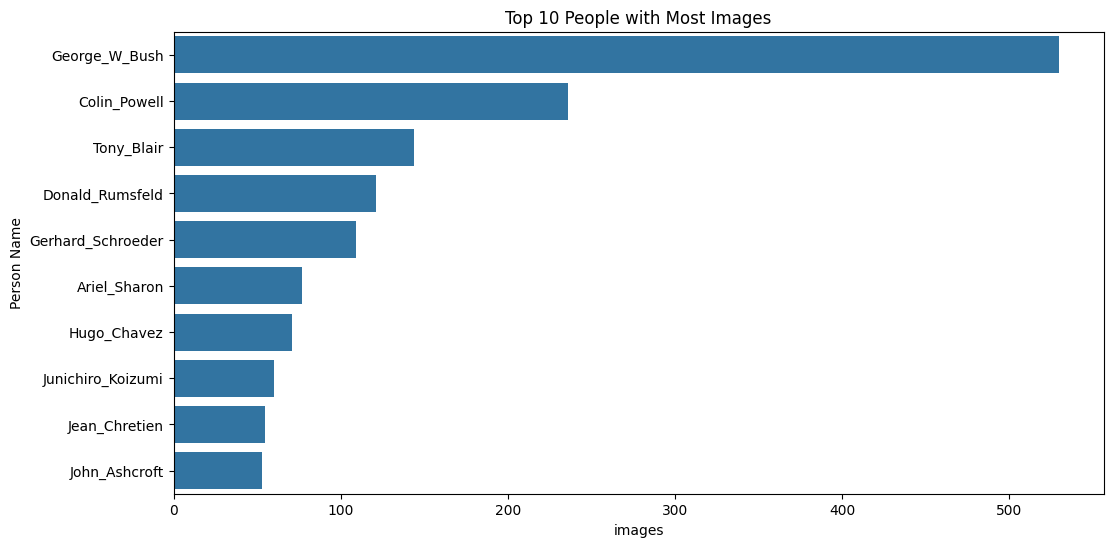

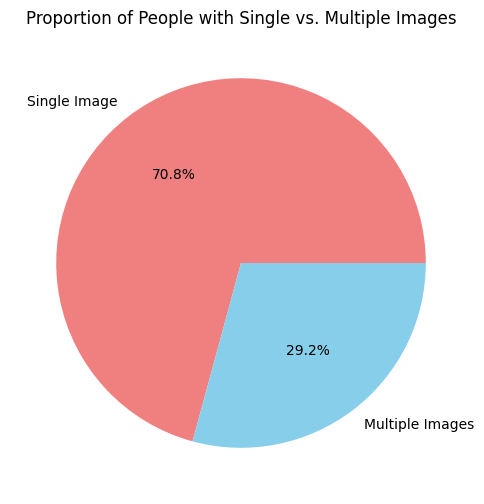

In [6]:
root_dir = "data/lfw-py"

dataset = LFWtripletDataset(root_dir=root_dir, transform=None)
top_people = dataset.statistics()


### Triplet Sampling Strategy

Since **70% of the dataset** consists of individuals with only a single image, these individuals cannot be used for anchor-positive pairing.  

To construct triplets:  
- For the **1,680 individuals** who have multiple images, each image can serve as an **anchor**.  
- A **positive sample** is randomly selected from another image of the same person.  
- A **negative sample** is randomly chosen from the **4,069 individuals** who have only one image, ensuring that the negative comes from a different identity.  

This approach in our opinion will maximize the use of available data while maintaining a meaningful triplet structure for training.



In [8]:
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()   
])
train_dataset = LFWtripletDataset(root_dir=root_dir, split="train", transform=transforms)
print(train_dataset.__len__())
test_dataset = LFWtripletDataset(root_dir=root_dir, split="test", transform=transforms)
print(test_dataset.__len__())

6671
2493


/home/user/zafara1/Cuda_Vision_Lab-/Session7/solution /Dataset.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3       0001
3       0002
3       0003
3       0004
5       0001
        ... 
4033    0002
4033    0003
4033    0004
4033    0005
4033    0006
Name: images, Length: 6671, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: f"{int(x):04d}" )
/home/user/zafara1/Cuda_Vision_Lab-/Session7/solution /Dataset.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0001
1       0001
2       0001
4       0001
6       0001
        ... 
4030    0001
4034    0001
4035    0001
4036    0001
4037    0001
Name: images, Length: 2854, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,

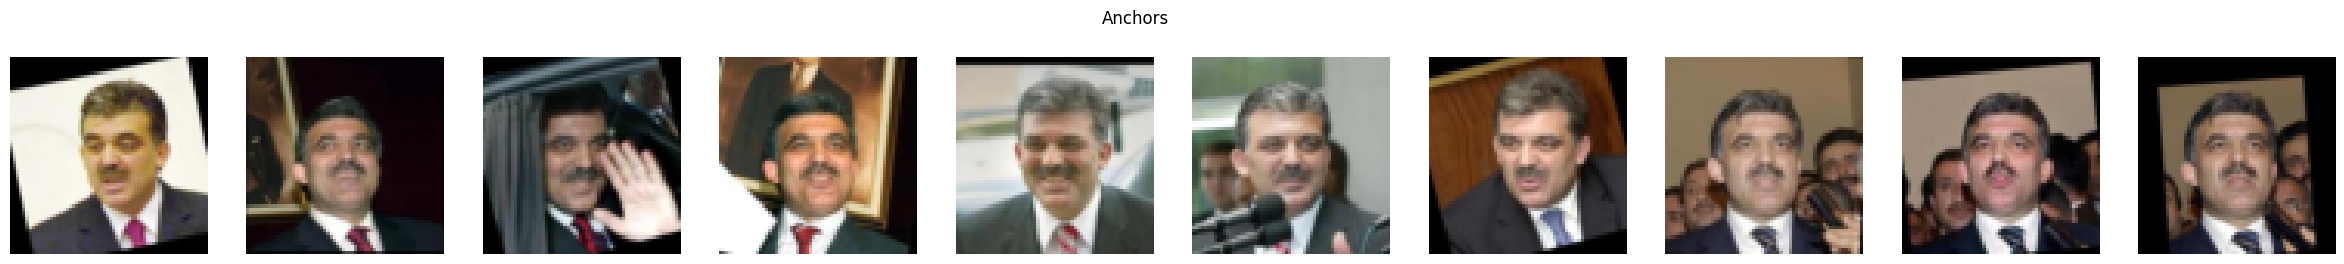

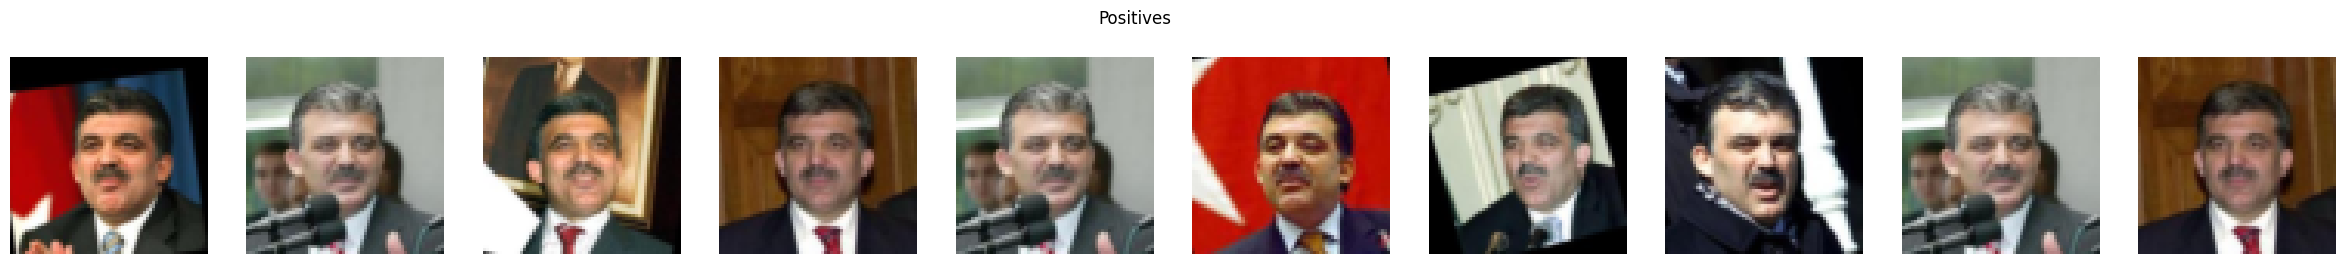

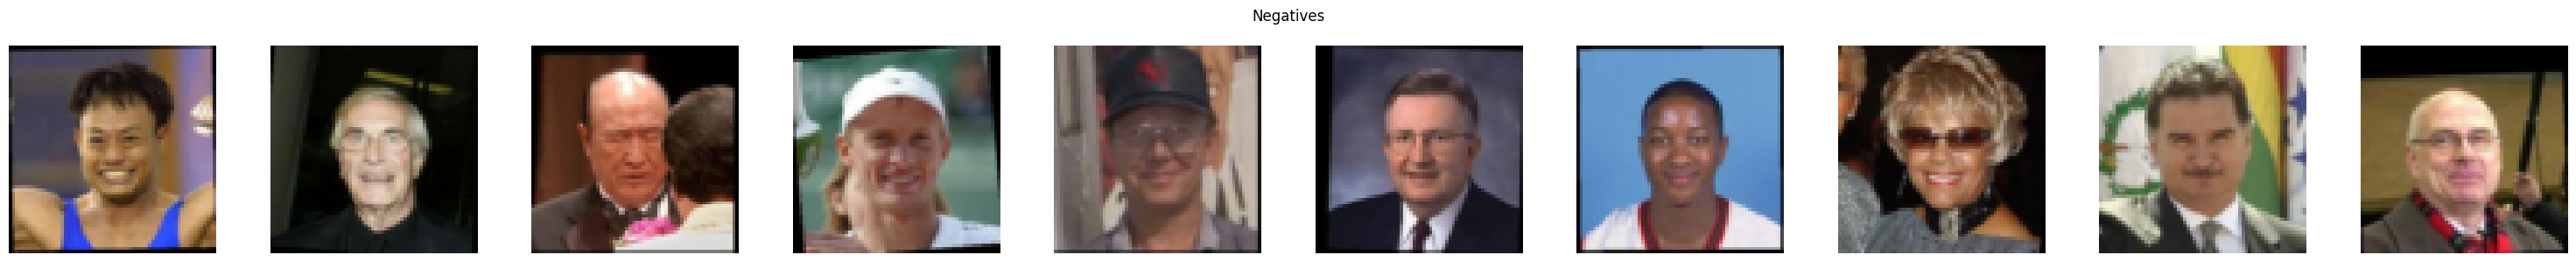

In [9]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30, 3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30, 3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30, 3))

for i in range(10):
    # Get the anchor, positive, and negative images from the dataset
    (anchor, positive, negative), _ = test_dataset[i]
    
    # Convert from (C, H, W) to (H, W, C) 
    anchor = anchor.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    positive = positive.permute(1, 2, 0).numpy()
    negative = negative.permute(1, 2, 0).numpy()
    
    # Display the images
    anchors[i].imshow(anchor)
    anchors[i].axis("off")
    
    positives[i].imshow(positive)
    positives[i].axis("off")
    
    negatives[i].imshow(negative)
    negatives[i].axis("off")

# Set titles
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negatives")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False) 


In [11]:
model = TriNetSiamese(input_size=(64,64))
model

/home/user/zafara1/miniconda3/envs/cuda_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/zafara1/miniconda3/envs/cuda_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TriNetSiamese(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [12]:
criterion = train.TripletLoss(margin=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
trainer = train.Trainer(model=model, criterion=criterion,optimizer=optimizer,train_loader=train_loader, test_loader=test_loader, n_iters=1000)

In [13]:
trainer.fit()

  0%|          | 0/1000 [00:00<?, ?it/s]

Train Iter 1: Loss=0.16011):   0%|          | 2/1000 [00:07<1:09:39,  4.19s/it]

Valid loss @ iteration 0: Loss=0.1471834891499617


Train Iter 251: Loss=0.04096):  25%|██▌       | 252/1000 [01:02<26:22,  2.12s/it]

Valid loss @ iteration 250: Loss=0.08546551269216415


Train Iter 501: Loss=0.0):  50%|█████     | 502/1000 [01:58<18:17,  2.20s/it]    

Valid loss @ iteration 500: Loss=0.08659308709395237


Train Iter 751: Loss=0.00305):  75%|███████▌  | 752/1000 [02:54<08:53,  2.15s/it]

Valid loss @ iteration 750: Loss=0.09390997437712474


Train Iter 999: Loss=0.0): 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]   


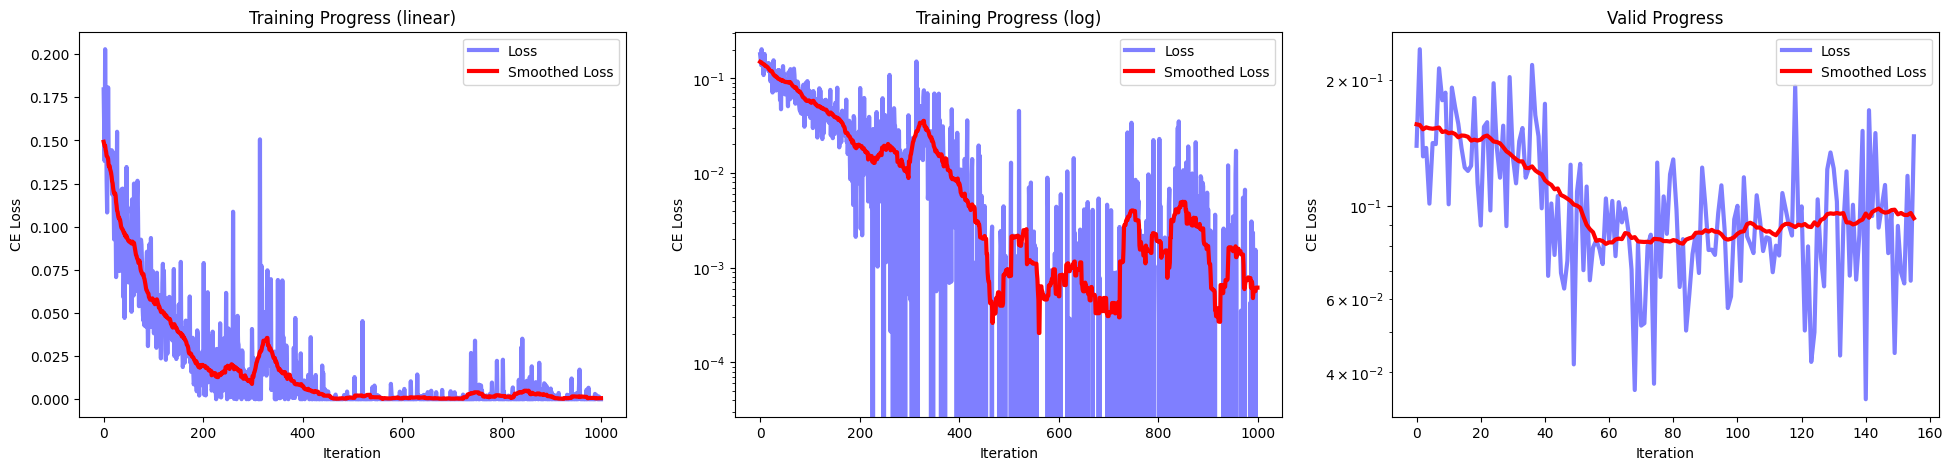

In [14]:
margins = [0, 0.2, 0.5, 1.0]
for margin in margins:  
    print(f"For a margin of {margin}")
    model = TriNetSiamese(input_size=(64,64))
    criterion = train.TripletLoss(margin=margin)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
    trainer = train.Trainer(model=model, criterion=criterion,optimizer=optimizer,train_loader=train_loader, test_loader=test_loader, n_iters=1000)
    trainer.fit()
    trainer.visualize_progress()

In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import numpy as np
from collections import Counter

In [16]:
device = trainer.device
model = model.eval()

In [56]:
test_load = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=True) 

In [45]:
(img,_,_),(lbl,_,_) = next(iter(test_load))

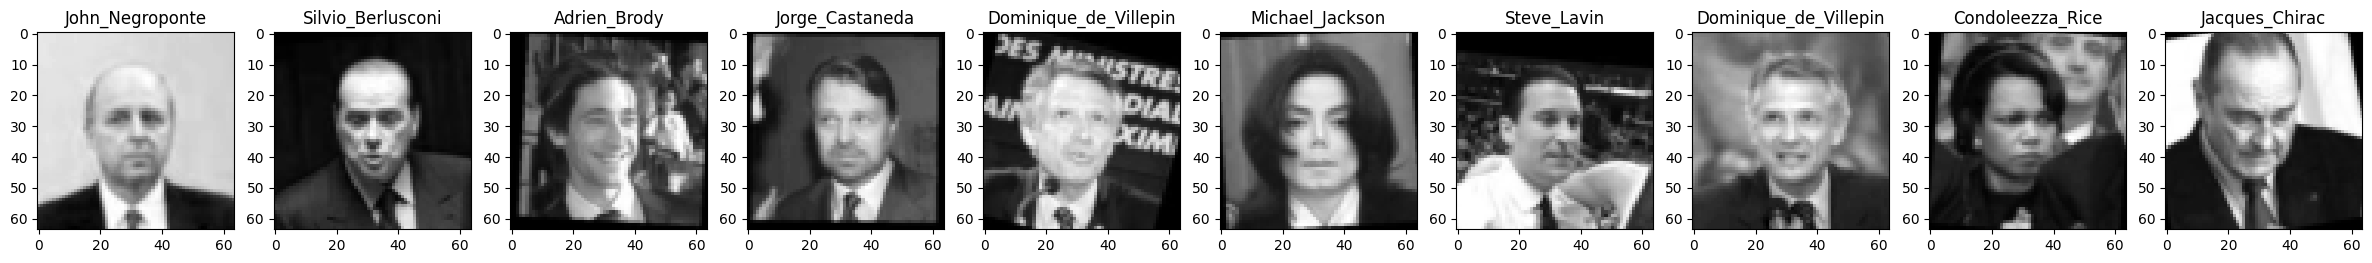

In [46]:
fig, ax = plt.subplots(1,10, figsize=(30,3))
for i in range(10):
    ax[i].imshow(img[i,0], cmap="gray")
    ax[i].set_title(lbl[i])
plt.show()

In [41]:
top_classes = top_people["name"].tolist()

In [47]:
imgs_flat = []
embs = []
labels = []
with torch.no_grad():
    for (anchor, _, _), (lbl,_, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)
        
        labels.append(lbl)
        embs.append(anchor_emb.cpu())
        imgs_flat.append(anchor.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

In [34]:
top_classes

['George_W_Bush',
 'Colin_Powell',
 'Tony_Blair',
 'Donald_Rumsfeld',
 'Gerhard_Schroeder',
 'Ariel_Sharon',
 'Hugo_Chavez',
 'Junichiro_Koizumi',
 'Jean_Chretien',
 'John_Ashcroft']

In [49]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

In [99]:
def display_projections(points, labels, ax=None, legend=None, top_k=10):
    """ Displaying low-dimensional data projections for top-k most frequent labels """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    # Calculate the frequency of each label
    label_counter = Counter(labels)
    
    # Get the top-k most frequent labels
    top_labels = [label for label, _ in label_counter.most_common(top_k)]
    
    # Filter points and labels to include only the top-k labels
    mask = np.isin(labels, top_labels)
    filtered_points = points[mask]
    filtered_labels = labels[mask]
    
    # Map filtered string labels to unique integers
    unique_labels = np.unique(filtered_labels)
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    
    # Convert string labels to integers for indexing
    int_labels = np.array([label_to_int[label] for label in filtered_labels])
    
    # Generate legend if not provided
    if legend is None:
        legend = [f"Class {label}" for label in unique_labels]
    
    # Create a plot if no axis is provided
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot each class
    for i, label in enumerate(unique_labels):
        idx = np.where(filtered_labels == label)  # Find indices of the current class
        ax.scatter(filtered_points[idx, 0], filtered_points[idx, 1], label=legend[i], c=COLORS[i % len(COLORS)])
    
    ax.legend(loc="best")
    

In [100]:
print(len(labels))
print(len(np.unique(labels)))

2493
496


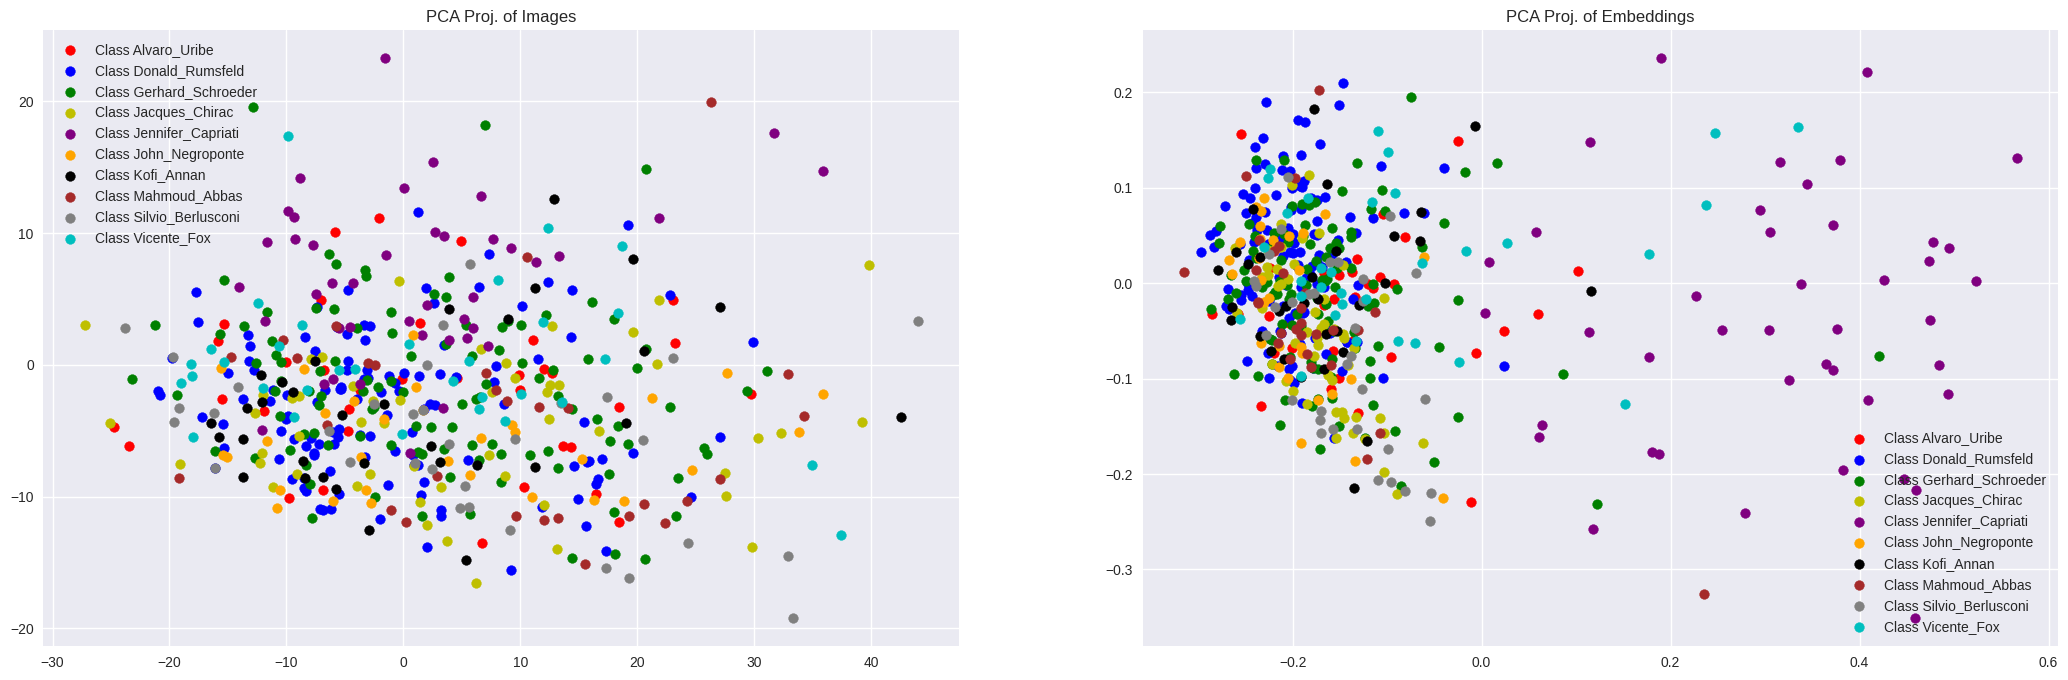

In [101]:
N = len(labels) - 1
plt.style.use('seaborn-v0_8')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], labels[:N], ax=ax[1])
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()


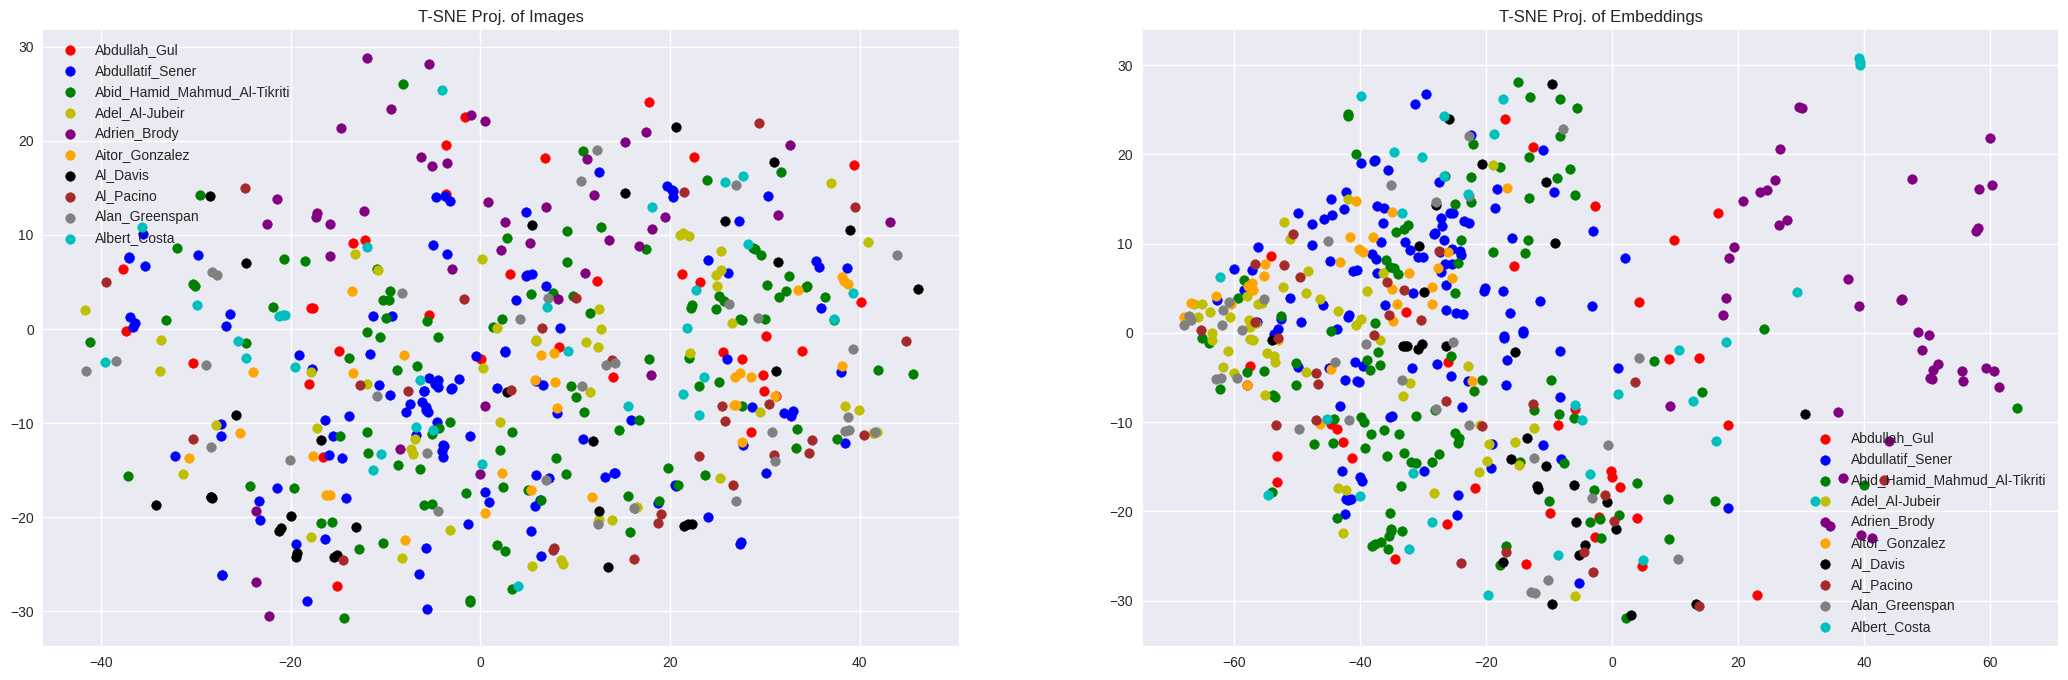

In [102]:
N = len(labels) - 1
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=np.unique(labels))
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], labels[:N], ax=ax[1], legend=np.unique(labels))
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()